# RANSAC plane detection demo
- *Author:* Chris Hodapp
- *Date:* 2017 December 3
- As far as I'm concerned, this code is public domain since it's just a textbook algorithm
- Scan below is from http://kos.informatik.uni-osnabrueck.de/3Dscans/
- The below is a rudimentary implementation of algorithm 1 of http://www.ipb.uni-bonn.de/pdfs/Yang2010Plane.pdf and part of algorithm 2.
- Particularly, it progressively does the following on a point cloud:
  - Finds the best plane it can in some number of iterations (where "best" means that the plane has the largest *support*, i.e. largest number of points that are within some threshold of the plane; if this is identical, it breaks ties by the plane has the lowest standard deviation of the distance of each point in the support from the plane.)
  - Removes the points on that plane's support, and repeats.

In [1]:
import numpy
import os

In [2]:
array_file = "lecturehall1.pose1.object1.label.npy"
# Loading from CSV is slow, so try NumPy array first:
if os.path.isfile(array_file):
    data = numpy.load(array_file)
else:
    # We only need 32-bit floats and the first 3 columns
    # (X, Y, and Z)
    csv_file = "lecturehall1.pose1.object1.label.csv"
    data = numpy.loadtxt(csv_file, delimiter=",", dtype=numpy.float32, usecols=(0,1,2))
    numpy.save(array_file, data)

In [3]:
data

array([[   2.56708002,  104.88932037, -180.63671875],
       [   2.56151009,  104.92838287, -180.41195679],
       [   2.55689907,  105.00483704, -180.25210571],
       ..., 
       [   0.48025799,  148.86096191,  -86.00698853],
       [   0.479193  ,  149.05101013,  -85.97846985],
       [   0.47685301,  148.89271545,  -85.75309753]], dtype=float32)

In [4]:
data.min(axis=0)

array([-194.32019043, -866.76367188, -256.21789551], dtype=float32)

In [5]:
data.max(axis=0)

array([ 806.84796143,  155.51104736,  152.89866638], dtype=float32)

In [6]:
data.mean(axis=0)

array([ 40.96011353, -45.97510529, -56.19637299], dtype=float32)

In [7]:
# Run one iteration of plane-detection RANSAC given an array
# of points, which needs shape (N,3), and a threshold for a
# point to be considered as "on" a plane.
# 
# Returns (support, std, n, d):
# support -- Boolean array of length N giving this plane's support.
#            support[i] is True if point i lies on the plane,
#            otherwise False.
# std -- Standard deviation of the point-plane distance for
#        each point in the support; gives a rough measure of
#        goodness of fit.
# n -- Array containing (a,b,c) for plane parameters.
# d -- Scalar for 'd' parameter of plane. Overall plane equation
#      is ax + by + cz + d = 0.
def ransac_iter(pts, thresh):
    # Choose indices of 3 unique points:
    i0, i1, i2 = numpy.random.choice(pts.shape[0], 3)
    # Get the points themselves:
    p0, p1, p2 = pts[i0, :], pts[i1, :], pts[i2, :]

    # Find plane these points lie on:
    n = numpy.cross(p1 - p0, p2 - p0)
    n /= numpy.linalg.norm(n)
    d = -n.dot(p0)

    # Compute point-plane distance for all points:
    dist = numpy.abs(n.dot(pts.T) + d)
    # Find support (all points lying within some threshold):
    support = dist < thresh
    std = dist[support].std()
    return support, std, n, d

In [8]:
# Input data is in 'points' (one row per 3D point):
points = data
# How many planes to find:
num_planes = 6
# Distance threshold for a point to be "on" a plane, in
# the same units as the point cloud:
# (depends on noise levels and real-world units)
thresh = 5
# How many RANSAC iterations to run (depends on noise levels
# and geometry):
ransac_iters = 200

# ns/ds contain the parameters for each plane found:
ns = []
ds = []
# 'planes' assigns every point either to a plane number, or -1
# for unassigned points:
planes = numpy.zeros((data.shape[0],), dtype=numpy.int16)
planes[:] = -1
for plane in range(num_planes):
    mask = planes < 0
    print("Plane {0}, starting at {1} points".format(plane, mask.sum()))
    best_num_support = 0
    best_support = []
    best_std = numpy.inf
    best_n = None
    best_d = None
    for i in range(ransac_iters):
        # Note that we run RANSAC only on unassigned points:
        support, std, n, d = ransac_iter(points[mask,:], thresh)
        num_support = support.sum()
        if num_support > best_num_support or (num_support == best_num_support and std < best_std):
            best_num_support = num_support
            best_support = support
            best_std = std
            best_n = n
            best_d = d
            print("Plane {0}, iter {1}: support={2}, std={3} for n={4}, d={5}".format(
                plane, i, best_num_support, best_std, best_n, best_d))
    ns.append(best_n)
    ds.append(best_d)
    # Every point in best_support now is considered to be on
    # that 'best' plane - so assign them all to the current
    # plane:
    m = planes[mask]
    m[best_support] = plane
    planes[mask] = m
    # (best_support refers to the masked array, not to 'planes'.
    # The multi-step assign is a fluke of how NumPy does views.)

Plane 0, starting at 22253519 points
Plane 0, iter 0: support=580817, std=1.4434025287628174 for n=[-0.56938601 -0.29301271 -0.76807749], d=-8.835225105285645
Plane 0, iter 3: support=4099590, std=0.5956542491912842 for n=[ 0.98336273  0.18075432 -0.01804597], d=159.4771270751953
Plane 0, iter 50: support=5230468, std=0.4156494736671448 for n=[ 0.02617571  0.99963874 -0.00610161], d=-149.57830810546875
Plane 1, starting at 17023051 points
Plane 1, iter 0: support=672138, std=1.4648746252059937 for n=[-0.96623236 -0.24816425  0.06935106], d=-140.56996154785156
Plane 1, iter 7: support=1734356, std=1.3935234546661377 for n=[ 0.98121828  0.18346606  0.05958949], d=155.55950927734375
Plane 1, iter 18: support=4380125, std=1.377360463142395 for n=[-0.98398161 -0.17416245 -0.03804727], d=-166.01556396484375
Plane 1, iter 102: support=4576530, std=1.3039993047714233 for n=[ 0.98499566  0.17139871  0.02014948], d=165.90187072753906
Plane 2, starting at 12446521 points
Plane 2, iter 0: support=

## Visualization
- (not very good visualization; matplotlib is just what I had handy)

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib

In [16]:
# Randomly pick 1000 points to visualize (we can't visualize
# this at anywhere near full-res in matplotlib):
pts2 = points[planes > 0, :]
planes2 = planes[planes > 0]
idxs = numpy.random.choice(pts2.shape[0], 5000, False)
pts_red = numpy.concatenate(
    (pts2[idxs,:], (planes2[idxs] + 1)[:,numpy.newaxis]), axis=1)

<IPython.core.display.Javascript object>


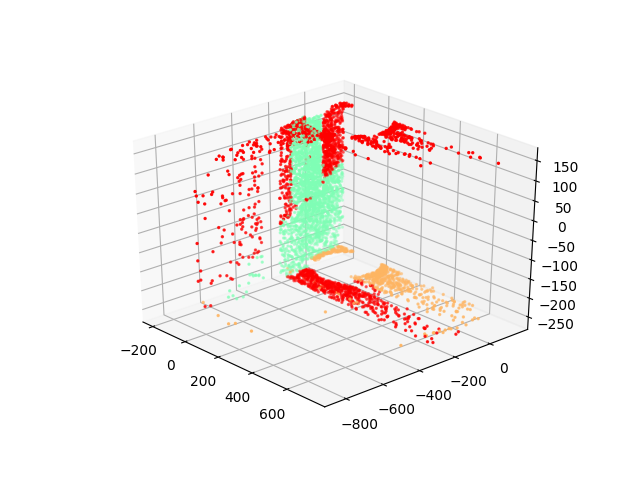

In [17]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

cmap=plt.cm.rainbow
norm = matplotlib.colors.BoundaryNorm(numpy.arange(6), cmap.N)

x, y, z, c = pts_red.T
ax.scatter(x, y, z, c=c, s=2, cmap=cmap, norm=norm)

plt.show()